## Model for Breast Cancer
- DEGs from MCF-7 cell line after HRG stimulation (2H vs. 0H) are used
- ErbB2/HER2 governs CDK4 inhibitor sensitivity and the timing and irreversibility of the G1/S transition by altering c-Myc and cyclin D function (Nagasato Ichikawa A et al., 2024)

In [3]:
import os
from typing import Optional, List, Dict, Any, Tuple
from tqdm import tqdm
import pandas as pd
import numpy as np
from sklearn.preprocessing import normalize
import gseapy as gp

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)

mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14
mpl.rcParams['axes.labelsize'] = 16
mpl.rcParams['axes.titlesize'] = 16

In [5]:
### Utils
import logging

# Check if no a
# handlers are already set, then configure basicConfig
if not logging.getLogger().hasHandlers():
    logging.basicConfig(
        level=logging.INFO,  # Output logs of level INFO and above
        format="%(asctime)s [%(levelname)s] %(message)s",
    )
else:
    # If handlers already exist, set the log level for the existing handlers
    logging.getLogger().setLevel(logging.INFO)

logger = logging.getLogger(__name__)
logger.info("Test log output: This is an INFO level message.")

2025-07-21 11:17:49,368 [INFO] Test log output: This is an INFO level message.


,genes,X0H_1,X0H_2,X0H_3,X2H_1,X2H_2,X2H_3,X4H_1,X4H_2,X4H_3,...,inh_16H_3,inh_20H_1,inh_20H_2,inh_20H_3,inh_24H_1,inh_24H_2,inh_24H_3,inh_28H_1,inh_28H_2,inh_28H_3
0,WASH7P,1.772917,1.635218,1.715263,1.914306,2.054260,1.893050,2.184573,1.753216,1.997563,...,1.618507,0.955811,1.553470,1.759783,2.670937,2.104836,2.399369,2.716928,2.607500,2.638843
1,LOC729737,2.789978,2.677148,2.352704,3.561382,3.351452,3.526207,3.489923,2.613668,2.689378,...,1.093148,1.188922,0.947219,1.534769,2.564053,2.596073,2.458342,2.716928,2.125813,2.766849
2,LOC102723897,1.237936,0.863246,1.014804,1.773044,1.604327,1.570793,2.465302,1.775249,2.087191,...,1.463715,0.549377,1.038461,-0.319258,1.279274,1.658281,1.397392,1.941445,1.780817,1.635889
3,LOC100134822,-0.175516,-0.057420,-0.400317,1.043795,0.652314,0.806688,1.261601,-1.271955,-0.479731,...,-1.268022,-1.174654,-1.259996,-0.319258,-0.842707,-0.752468,-0.880760,-0.480865,-0.715082,-0.554884
4,LOC100133331,0.157861,0.079061,-0.313894,0.731042,0.383633,0.716310,1.261601,0.374075,-0.039400,...,-1.461310,-1.415195,-1.495722,-1.145099,0.017718,0.042380,0.331683,-0.272067,-0.930211,-0.328640


(15456, 40)

,Geneid,logfc_2H,pvalue_2H,qvalue_2H,logfc_4H,pvalue_4H,qvalue_4H,logfc_8H,pvalue_8H,qvalue_8H,...,qvalue_16H,logfc_20H,pvalue_20H,qvalue_20H,logfc_24H,pvalue_24H,qvalue_24H,logfc_28H,pvalue_28H,qvalue_28H
0,WASH7P,0.255961,0.175025,0.276040,0.289799,0.125971,0.172940,0.210291,0.264313,0.326896,...,0.038977,0.401758,3.516707e-02,0.053117,0.215925,0.258603,0.313733,0.061923,0.747666,0.781810
1,LOC729737,0.872690,0.000030,0.000129,0.379153,0.057360,0.086041,-0.941757,0.000069,0.000175,...,0.000024,-1.347189,3.810000e-07,0.000001,-0.970436,0.000060,0.000141,-0.669147,0.002926,0.004822
2,LOC102723897,0.627646,0.014947,0.034873,1.128664,0.000022,0.000060,0.451027,0.079906,0.113015,...,0.127024,-0.355414,2.061692e-01,0.258083,-0.610042,0.038779,0.056608,0.124216,0.639316,0.682927
3,LOC100134822,1.135654,0.010963,0.026588,0.499880,0.271789,0.338374,-1.039533,0.052822,0.077977,...,0.000494,-1.844540,3.041114e-03,0.005662,-0.888245,0.096923,0.129993,-1.332164,0.020061,0.028981
4,LOC100133331,0.679177,0.057005,0.109736,0.710000,0.046943,0.071980,-0.617629,0.121432,0.164419,...,0.182345,-0.802759,5.395058e-02,0.078289,-0.514734,0.197517,0.246892,-0.951252,0.026013,0.036944


(15456, 25)

logfc > 2.0 & pval < 0.0001 : 306 genes


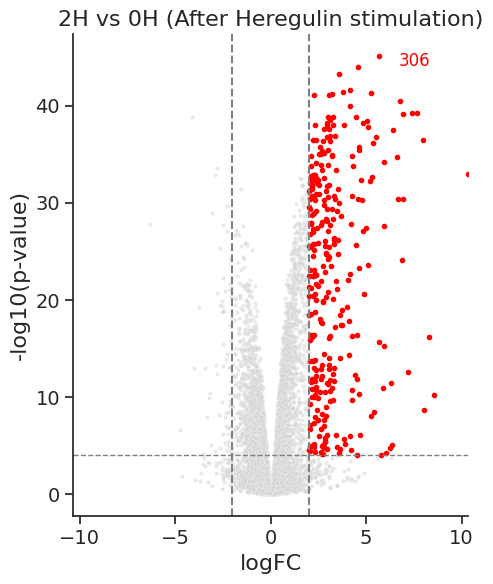

In [2]:
#################
### Defferential Expression Analysis
#################
# 1. Original data is from Nagasato Ichikawa A et al., 2024
logcpm_data = pd.read_csv("../data/fig7/MCF7_HRG_normalized_logCPM.csv")
display(logcpm_data.head())
display(logcpm_data.shape)

stat_results = pd.read_csv("../data/fig7/MCF7_HRG_logFC_adjP.csv")
genes = stat_results["Geneid"].values
display(stat_results.head())
display(stat_results.shape)

# 2. Here we focus on the 2H vs. 0H comparison
logfc_values = stat_results[f"logfc_2H"].values
pvalues = stat_results[f"qvalue_2H"].values
logp_values = -np.log10(pvalues)

logfc_cutoff = 2.0
pval_cutoff = 0.0001

# 3. Select only upregulated genes
sig_idxes = np.where((logfc_values > logfc_cutoff) & (pvalues < pval_cutoff))[0]
print(f"logfc > {logfc_cutoff} & pval < {pval_cutoff} : {len(sig_idxes)} genes")

degs = genes[sig_idxes].copy()

# 4. Plot
fig, ax = plt.subplots(figsize=(5, 6))
n_up_genes = len(sig_idxes)
xlim_abs = np.abs(logfc_values).max()

sns.scatterplot(x=logfc_values, y=logp_values, ax=ax, color="lightgrey", alpha=0.5, s=9)
ax.scatter(logfc_values[sig_idxes], logp_values[sig_idxes], color="red", label="Upregulated", s=9)
ax.axhline(-np.log10(pval_cutoff), color="grey", linestyle="--", lw=1)
ax.axvline(logfc_cutoff, color="grey", linestyle="--", lw=1.5)
ax.axvline(-logfc_cutoff, color="grey", linestyle="--", lw=1.5)
ax.text(xlim_abs*0.65, logp_values.max()-1, f"{n_up_genes}", color="red")
ax.set_title(f"2H vs 0H (After Heregulin stimulation)")
ax.set_xlabel("logFC")
ax.set_ylabel("-log10(p-value)")
ax.set_xlim(-xlim_abs, xlim_abs)
ax.grid(False)
fig.tight_layout()
fig.savefig(f"../data/fig7/fig7.volcano_plot_2H_upregulated_logfc{logfc_cutoff}_q{pval_cutoff}.png", dpi=300, bbox_inches='tight')
plt.show()
plt.close(fig)

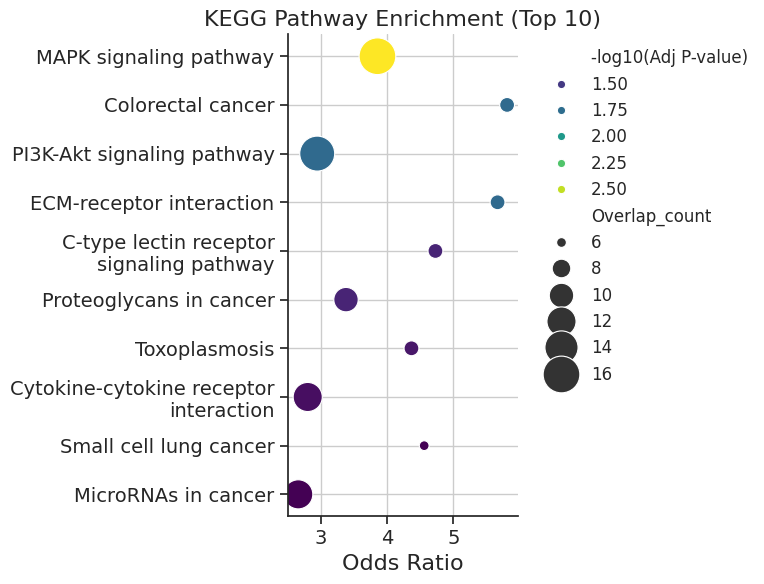

In [4]:
# 5. Perform Gene Set Enrichment Analysis (GSEA)

# db_names = ["MSigDB_Hallmark", "KEGG", "Reactome", "GO_BP", "GO_MF"]
# library_names = ["MSigDB_Hallmark_2020", "KEGG_2021_Human", "Reactome_2022", "GO_Biological_Process_2023", "GO_Molecular_Function_2023"]
db_names = ["KEGG"]
library_names = ["KEGG_2021_Human"]

for db_name, library_name in zip(db_names, library_names):
    os.makedirs(f"../data/fig7/{db_name}", exist_ok=True)
    enr = gp.enrichr(gene_list=degs.tolist(),
                        gene_sets=library_name,
                        organism='human',
                        outdir=None)
    df = enr.results.copy()
    save_path = f"../data/fig7/{db_name}/{library_name}_2H_upregulated.csv"
    df.to_csv(save_path, sep="\t", index=False)
    
    # Plotting the enrichment results
    df["-log10(Adj P-value)"] = -df["Adjusted P-value"].apply(lambda p: np.log10(p))
    df["Term"] = df["Term"].str.wrap(30)
    df["Overlap_count"] = df["Overlap"].apply(lambda x: int(x.split("/")[0]))
    df["Odds Ratio"] = df["Odds Ratio"].astype(float)

    top_n = 10
    df = df.sort_values(by="-log10(Adj P-value)", ascending=False).head(top_n)

    fig, ax = plt.subplots(figsize=(8, 6))

    sns.scatterplot(
        data=df,
        x="Odds Ratio",
        y="Term",
        size="Overlap_count",
        hue="-log10(Adj P-value)",
        sizes=(50, 700),
        palette="viridis",
        legend="brief",
        ax=ax
    )

    ax.set_title(f"{db_name} Pathway Enrichment (Top 10)")
    ax.set_xlabel("Odds Ratio")
    ax.set_ylabel("")
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', frameon=False, fontsize=12)
    ax.grid(True)
    fig.tight_layout()
    # fig.savefig(f"../data/fig7/{db_name}/{db_name}_enrichment_2H_upregulated.png", dpi=300, bbox_inches='tight')
    fig.savefig(f"../data/fig7/fig7.{db_name}_enrichment_2H_upregulated.png", dpi=300, bbox_inches='tight')
    plt.show()
    plt.close(fig)

In [6]:
#################################################################################
# Rank reaction equations based on gene importance, similarity, and DEG relevance
#################################################################################
# Step 1: Load reaction equations from BioModels (Glont et al., 2020)
# Step 2: Map gene symbols to each reaction equation
# Step 3: Compute three ranking-based scores for each reaction:
#   S1: Gene importance score using PageRank values
#   S2: Inter-gene similarity score based on cosine similarity
#   S3: DEG-related score based on similarity to DEGs
# Step 4: Rank all equations based on each score

logger = logging.getLogger(__name__)

class LLMText2ModelPipeline:
    def __init__(self,
                 pub_score_path: str,
                 emb_path: str,
                 emb_genes_path: str,
                 out_path: str,
                 biomodels_path: Optional[str] = None,
                 KEGG_path: Optional[str] = None,
                 WikiPathways_path: Optional[str] = None,
                 ) -> None:
        self.pub_score_path = pub_score_path
        self.emb_path = emb_path
        self.emb_genes_path = emb_genes_path
        self.out_path = out_path
        self.biomodels_path = biomodels_path
        self.KEGG_path = KEGG_path
        self.WikiPathways_path = WikiPathways_path

        self._initialize()
    
    def _initialize(self):
        # 1. Load data
        pub_score = pd.read_csv(self.pub_score_path)
        pub_score["z-score"] = (pub_score["pagerank"] - pub_score["pagerank"].mean()) / pub_score["pagerank"].std()
        logger.info("Loading publication score from: %s", self.pub_score_path)
        logger.info("Publication score head: \n%s", pub_score.head().to_string())
        self.gene2pubscore = dict(zip(pub_score["gene"], pub_score["z-score"]))
        
        # 2. Load embeddings
        embs = np.load(self.emb_path)
        self.embs = normalize(embs)
        self.mean, self.std = self.calc_stat_inter_sim(embs)
        
        # 3. Load emb_genes and define gene2idx
        emb_genes = np.load(self.emb_genes_path, allow_pickle=True)
        self.gene2idx = {gene: idx for idx, gene in enumerate(emb_genes)}
        logger.info(f"Loaded {len(emb_genes)} genes in embeddings")

        # 4. Load pathways
        if self.biomodels_path is not None:
            biomodels_df = pd.read_csv(self.biomodels_path)
            biomodels_df = biomodels_df.fillna("")

            # Filter for organism
            organisms2use = ["mammalia", "homo sapiens", "rattus", "mus musculus", "undefined"]
            biomodels_df["organism"] = biomodels_df["organism"].fillna("undefined")
            biomodels_df = biomodels_df[biomodels_df["organism"].apply(lambda x: any([o in x.lower() for o in organisms2use]))].reset_index(drop=True)
            self.biomodels_df = biomodels_df
            self.sorted_biomodels_df = None # # This will be populated with sorted data after rank_reactions() is called
            logger.info("Loaded Reactions from BioModels: %s", self.biomodels_df.shape)
        
        if self.KEGG_path is not None:
            kegg_df = pd.read_csv(self.KEGG_path)
            kegg_df = kegg_df.fillna("")
            kegg_df["genes"] = kegg_df.apply(lambda row: row["source_symbols"] if row["target_symbols"] == "" else row["target_symbols"] if row["source_symbols"] == "" else row["source_symbols"] + "," + row["target_symbols"], axis=1)
            self.kegg_df = kegg_df
            self.sorted_kegg_df = None # This will be populated with sorted data after rank_reactions() is called
            logger.info("Loaded Reactions from KEGG: %s", self.kegg_df.shape)
        
        if self.WikiPathways_path is not None:
            pass
            self.wikipathways_df = None
            self.sorted_wikipathways_df = None # This will be populated with sorted data after rank_reactions() is called
    
    def _compute_scores(self, genes_str: str, genes_of_interest_indices: List[int]) -> Tuple[float, float, float]:
            genes = [g.strip() for g in genes_str.split(",")]

            # publication score
            pub_scores = [self.gene2pubscore.get(g, 0) for g in genes]
            inter_pub_score = np.mean(pub_scores) if pub_scores else 0.0
            
            # inter-similarity score
            gene_indices = [self.gene2idx[g] for g in genes if g in self.gene2idx]
            if len(gene_indices) > 1:
                sims = self.calc_inter_sims(self.embs[gene_indices])
                sims = (sims - self.mean) / self.std
                inter_sim_score = np.mean(sims)
            else:
                inter_sim_score = 0.0

            # intra-similarity score
            if gene_indices:
                sims = self.calc_intra_sims(self.embs[gene_indices], self.embs[genes_of_interest_indices])
                sims = (sims - self.mean) / self.std
                intra_sim_score = np.mean(sims)
            else:
                intra_sim_score = 0.0

            return inter_pub_score, inter_sim_score, intra_sim_score
    
    def _add_rank_column(self, df: pd.DataFrame, score_list: List[float], score_col_name: str) -> None:
        rank_col_name = score_col_name.replace("_score", "_rank")
        s = pd.Series(score_list)
        df[rank_col_name] = s.rank(ascending=False, method="dense").values
        df[score_col_name] = score_list

        # Calculate Z-score
        z_col_name = score_col_name.replace("_score", "_zscore")
        df[z_col_name] = (s - s.mean()) / s.std()


    def rank_reactions(self, scope, genes_of_interest, genes_column_name="genes", weights=None):
        scope_lower = scope.lower()
        valid_scopes = ["biomodels", "kegg", "wikipathways"]
        assert scope_lower in valid_scopes, f"Invalid scope: {scope}"

        if scope_lower == "biomodels":
            df = self.biomodels_df
        elif scope_lower == "kegg":
            df = self.kegg_df
        elif scope_lower == "wikipathways":
            df = self.wikipathways_df
        
        assert genes_column_name in df.columns, f"Column '{genes_column_name}' not found in DataFrame of {scope}"

        genes_of_interest_indices = [self.gene2idx[gene] for gene in genes_of_interest if gene in self.gene2idx]
        if len(genes_of_interest_indices) == 0:
            raise ValueError(
                f"No valid genes_of_interest found in the embedding: {genes_of_interest}"
            )
        logger.info(f"Genes of interest: {len(genes_of_interest)} genes.")
        
        # Calculate scores
        scores = [self._compute_scores(genes_str, genes_of_interest_indices) for genes_str in tqdm(df[genes_column_name])]
        inter_pub_scores, inter_sim_scores, intra_sim_scores = zip(*scores)
        
        self._add_rank_column(df, inter_pub_scores, "inter_pub_score")
        self._add_rank_column(df, inter_sim_scores, "inter_sim_score")
        self._add_rank_column(df, intra_sim_scores, "intra_sim_score")

        if weights is None:
            weights = np.array([1., 1., 1.])
        
        weights = np.array(weights).astype(float)
        weights /= np.sum(weights)
        averaged_rank = df["inter_sim_rank"] * weights[0] + df["inter_pub_rank"] * weights[1] + df["intra_sim_rank"] * weights[2]
        df["averaged_rank"] = averaged_rank

        # averaged Z-scaore
        averaged_zscore = df["inter_sim_zscore"] * weights[0] + df["inter_pub_zscore"] * weights[1] + df["intra_sim_zscore"] * weights[2]
        df["averaged_zscore"] = averaged_zscore
        df["averaged_zscore_rank"] = averaged_zscore.rank(ascending=False, method="dense").values
        
        # consolidation
        sorted_df = df.groupby(genes_column_name).agg(list).reset_index()
        sorted_df["count"] = sorted_df["inter_pub_rank"].apply(lambda x: len(x))

        sorted_df["inter_pub_rank"] = sorted_df["inter_pub_rank"].apply(lambda x: np.nanmean(x))
        sorted_df["inter_pub_score"] = sorted_df["inter_pub_score"].apply(lambda x: np.nanmean(x))
        sorted_df["inter_pub_zscore"] = sorted_df["inter_pub_zscore"].apply(lambda x: np.nanmean(x))
        sorted_df["inter_sim_rank"] = sorted_df["inter_sim_rank"].apply(lambda x: np.nanmean(x))
        sorted_df["inter_sim_score"] = sorted_df["inter_sim_score"].apply(lambda x: np.nanmean(x))
        sorted_df["inter_sim_zscore"] = sorted_df["inter_sim_zscore"].apply(lambda x: np.nanmean(x))
        sorted_df["intra_sim_rank"] = sorted_df["intra_sim_rank"].apply(lambda x: np.nanmean(x))
        sorted_df["intra_sim_score"] = sorted_df["intra_sim_score"].apply(lambda x: np.nanmean(x))
        sorted_df["intra_sim_zscore"] = sorted_df["intra_sim_zscore"].apply(lambda x: np.nanmean(x))
        sorted_df["averaged_rank"] = sorted_df["averaged_rank"].apply(lambda x: np.nanmean(x))
        sorted_df["averaged_zscore"] = sorted_df["averaged_zscore"].apply(lambda x: np.nanmean(x))
        sorted_df["averaged_zscore_rank"] = sorted_df["averaged_zscore_rank"].apply(lambda x: np.nanmean(x))
        sorted_df = sorted_df.sort_values("averaged_rank").reset_index(drop=True)

        if scope_lower == "biomodels":
            self.sorted_biomodels_df = sorted_df
        elif scope_lower == "kegg":
            self.sorted_kegg_df = sorted_df
        elif scope_lower == "wikipathways":
            self.sorted_wikipathways_df = sorted_df
        
        return sorted_df

    @staticmethod
    def calc_stat_inter_sim(embs):
        sim = embs @ embs.T
        upper_triangle_indices = np.triu_indices(sim.shape[0], k=1)
        upper_triangle_values = sim[upper_triangle_indices]
        return np.mean(upper_triangle_values), np.std(upper_triangle_values)
    
    @staticmethod
    def calc_inter_sims(embs):
        sim = embs @ embs.T
        upper_triangle_indices = np.triu_indices(sim.shape[0], k=1)
        upper_triangle_values = sim[upper_triangle_indices]
        return upper_triangle_values
    
    @staticmethod
    def calc_intra_sims(embs1, embs2):
        sim = embs1 @ embs2.T
        return sim.flatten()


# Note: The file 'BioModels_Parameters_modified.csv' is a manually curated version of BioModels Parameters
# (https://www.ebi.ac.uk/biomodels/parameterSearch) with human gene symbols mapped to each reaction.

t2m_pipeline = LLMText2ModelPipeline(
    pub_score_path="../data/fig2-3/pagerank/pagerank_breast_cancer.csv",
    emb_path="../data/fig4/GeneRelNet_Breast_Cancer/gene_vec_256.npy",
    emb_genes_path="../data/fig4/GeneRelNet_Breast_Cancer/gene_ids.npy",
    out_path="../data/fig7",
    biomodels_path="../data/fig7/BioModels_Parameters_modified.csv",
    KEGG_path=None,
)

2025-07-21 11:41:23,808 [INFO] Loading publication score from: ../data/fig2-3/pagerank/pagerank_breast_cancer.csv
2025-07-21 11:41:23,810 [INFO] Publication score head: 
    gene  pagerank    z-score
0   AKT1  0.002812  27.662775
1   TP53  0.002556  25.092562
2  ERBB2  0.002102  20.541077
3  NFKB1  0.002020  19.721008
4   EGFR  0.001939  18.901040
2025-07-21 11:41:25,414 [INFO] Loaded 18606 genes in embeddings
2025-07-21 11:41:27,680 [INFO] Loaded Reactions from BioModels: (41829, 35)


2025-07-21 11:49:49,962 [INFO] Genes of interest: 306 genes.
100%|██████████| 41829/41829 [00:01<00:00, 27669.01it/s]
2025-07-21 11:49:52,676 [INFO] Genes of interest: 306 genes.
100%|██████████| 41829/41829 [00:01<00:00, 27666.36it/s]
2025-07-21 11:49:55,436 [INFO] Genes of interest: 306 genes.
100%|██████████| 41829/41829 [00:01<00:00, 27877.77it/s]
2025-07-21 11:49:58,080 [INFO] Genes of interest: 306 genes.
100%|██████████| 41829/41829 [00:01<00:00, 27911.90it/s]
2025-07-21 11:50:00,732 [INFO] Genes of interest: 306 genes.
100%|██████████| 41829/41829 [00:01<00:00, 27802.63it/s]
2025-07-21 11:50:03,487 [INFO] Genes of interest: 306 genes.
100%|██████████| 41829/41829 [00:01<00:00, 27689.65it/s]
2025-07-21 11:50:06,271 [INFO] Genes of interest: 306 genes.
100%|██████████| 41829/41829 [00:01<00:00, 27735.08it/s]
2025-07-21 11:50:08,930 [INFO] Genes of interest: 306 genes.
100%|██████████| 41829/41829 [00:01<00:00, 27506.22it/s]
2025-07-21 11:50:11,720 [INFO] Genes of interest: 306 ge

Unique reactions: 25
--------------------


100%|██████████| 41829/41829 [00:01<00:00, 28092.33it/s]
2025-07-21 11:50:14,369 [INFO] Genes of interest: 306 genes.
100%|██████████| 41829/41829 [00:01<00:00, 28053.44it/s]
2025-07-21 11:50:17,133 [INFO] Genes of interest: 306 genes.
100%|██████████| 41829/41829 [00:01<00:00, 27943.41it/s]
2025-07-21 11:50:19,784 [INFO] Genes of interest: 306 genes.
100%|██████████| 41829/41829 [00:01<00:00, 28025.27it/s]
2025-07-21 11:50:22,552 [INFO] Genes of interest: 306 genes.
100%|██████████| 41829/41829 [00:01<00:00, 28221.44it/s]
2025-07-21 11:50:25,196 [INFO] Genes of interest: 306 genes.
100%|██████████| 41829/41829 [00:01<00:00, 28020.31it/s]
2025-07-21 11:50:27,970 [INFO] Genes of interest: 306 genes.
100%|██████████| 41829/41829 [00:01<00:00, 27450.02it/s]
2025-07-21 11:50:30,664 [INFO] Genes of interest: 306 genes.
100%|██████████| 41829/41829 [00:01<00:00, 28109.27it/s]
/tmp/ipykernel_1078718/387369302.py:45: UserWarning: set_ticklabels() should only be used with a fixed number of tick

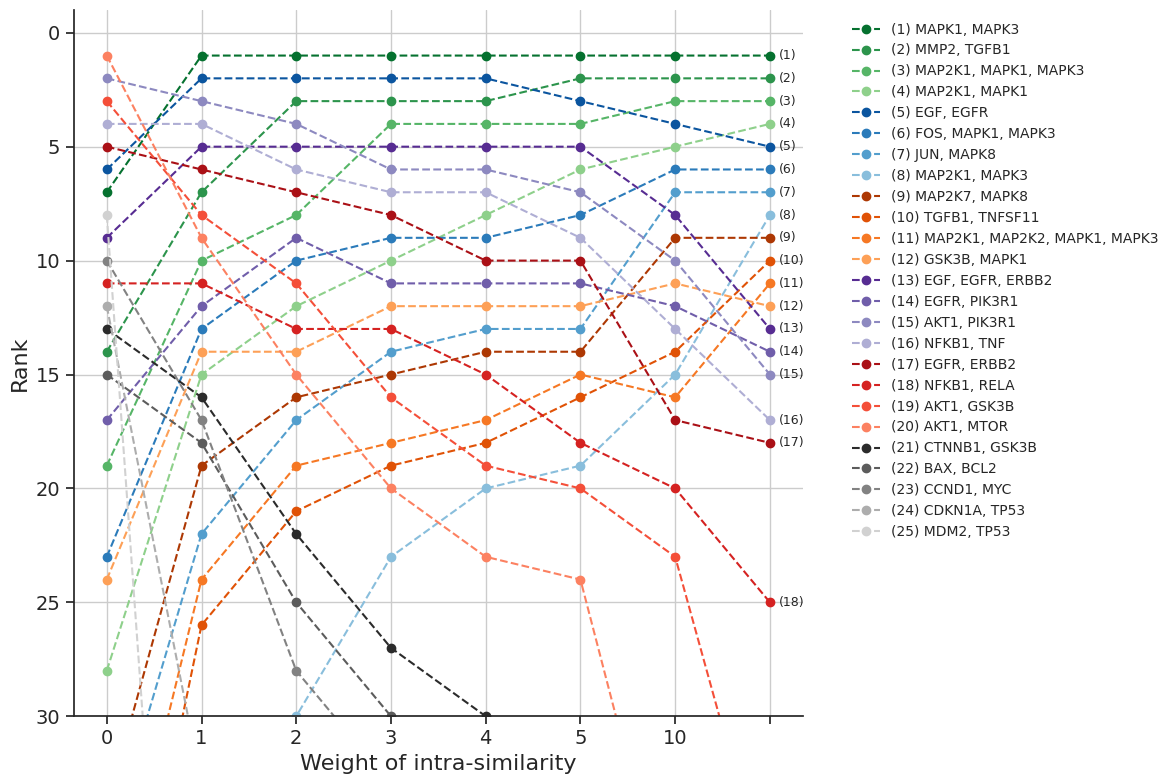

/tmp/ipykernel_1078718/387369302.py:45: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([0, 0, 1, 2, 3, 4, 5, 10])


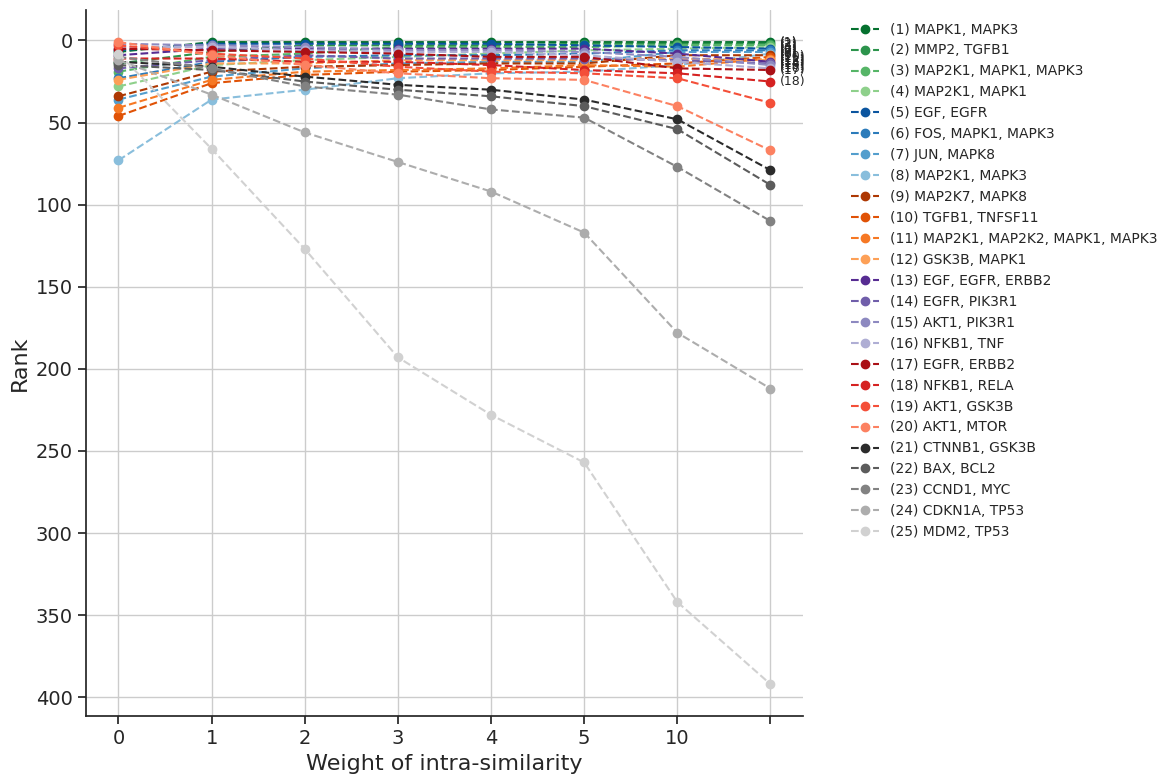

In [7]:
# Investigate the impact of varying weights for S1, S2, and S3 when calculating the integrated score,
# particularly assigning greater weight to the DEG-related score (S3)

# 1. Select top 15 reactions based on different weights
top15_reactions = []
top15_reactions_unique = set()
for w in [0, 1, 2, 3, 4, 5, 10, 20]:
    sorted_biomodels_df = t2m_pipeline.rank_reactions("biomodels", genes_of_interest=degs, genes_column_name="entity_gene_symbols", weights=[1, 1, w])
    top15_reactions.append(sorted_biomodels_df["entity_gene_symbols"].values[:15].tolist())
    top15_reactions_unique.update(sorted_biomodels_df["entity_gene_symbols"].values[:15].tolist())
print(f"Unique reactions: {len(top15_reactions_unique)}")
print("-"*20)

# 2. Prepare data for plotting
plot_reactions = list(top15_reactions_unique)
plot_ranks = []
for w in [0, 1, 2, 3, 4, 5, 10, 20]:
    sorted_biomodels_df = t2m_pipeline.rank_reactions("biomodels", genes_of_interest=degs, genes_column_name="entity_gene_symbols", weights=[1, 1, w])
    entity2rank = dict(zip(sorted_biomodels_df["entity_gene_symbols"], sorted_biomodels_df.index.values))
    plot_ranks.append([entity2rank[reaction] for reaction in plot_reactions])

# 3. Sort by the rank at weight=10
sorted_indice = np.argsort(np.array(plot_ranks[-1]))

plot_reactions_sorted = np.array(plot_reactions)[sorted_indice]
plot_ranks_sorted = np.array(plot_ranks)[:, sorted_indice] + 1

custom_palette = (sns.color_palette("Greens")[::-1][:4] + sns.color_palette("Blues")[::-1][:4] +
                  sns.color_palette("Oranges")[::-1][:4] + sns.color_palette("Purples")[::-1][:4] +
                  sns.color_palette("Reds")[::-1][:4] + sns.color_palette("Greys")[::-1][:5])

# 4. Plot the ranks
def plot(ylim=True):
    fig, ax = plt.subplots(figsize=(12,8))
    for i, (ranks, reaction) in enumerate(zip(plot_ranks_sorted.T, plot_reactions_sorted)):
        ax.plot(ranks, label=f"({i+1}) " + reaction, linestyle="--", marker="o", color=custom_palette[i])

    for i in range(1, plot_ranks_sorted.shape[1]+1):
        plt_rank = plot_ranks_sorted[-1][i-1]
        if plt_rank > 30:
            continue
        ax.text(plot_ranks_sorted.shape[0]-1+0.1, plt_rank, f"({i})", fontsize=9, va="center")

    ax.grid()
    ax.set_xticklabels([0, 0, 1, 2, 3, 4, 5, 10])
    ax.set_xlabel("Weight of intra-similarity", fontsize=16)
    ax.set_ylabel("Rank", fontsize=16)
    if ylim:
        ax.set_ylim(-1, 30)
    ax.invert_yaxis()
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', frameon=False, fontsize=10)
    ax.grid(True)
    fig.tight_layout()
    if ylim:
        fig.savefig("../data/fig7/fig7.supple.ranked_biomodels_reactions_ylim.png", dpi=300, bbox_inches="tight")
    else:
        fig.savefig("../data/fig7/fig7.supple.ranked_biomodels_reactions.png", dpi=300, bbox_inches="tight")
    plt.show()
    plt.close(fig)
plot(ylim=True)
plot(ylim=False)

In [8]:
#####################
# Find reactions from BioModels
#####################
top15_reactions = []
top15_reactions_unique = set()

# Here we set the weight of DEG-related rank to 10, which is the same as in our paper.
w = 10
topk = 30

sorted_biomodels_df = t2m_pipeline.rank_reactions("biomodels", genes_of_interest=degs, genes_column_name="entity_gene_symbols", weights=[1, 1, w]).iloc[:topk, :]
sorted_biomodels_df.to_csv("../data/fig7/ranked_biomodels_reactions_weight10.csv", index=False)
display(sorted_biomodels_df)

2025-07-21 11:52:33,689 [INFO] Genes of interest: 306 genes.
100%|██████████| 41829/41829 [00:01<00:00, 27671.90it/s]


,entity_gene_symbols,entity,entity_id,initial concentration/amount,reaction with entity labels,reaction with entity ids,reactants,products,modifiers,model,...,inter_sim_rank,inter_sim_score,inter_sim_zscore,intra_sim_rank,intra_sim_score,intra_sim_zscore,averaged_rank,averaged_zscore,averaged_zscore_rank,count
0,"MAPK1, MAPK3","[[Ribosomal protein S6 kinase [nucleoplasm]], ...","[pRSKn, species 10, species 11]","[0.0 mmol, 0.0 mmol, 600000.0 mmol]","[=> pRSKn; ppERKn, species_10 => species_11; s...","[=> pRSKn; ppERKn, species_10 => species_11; s...","[, species_10$ErkActive$http://identifiers.org...",[pRSKn$pRSKn$http://identifiers.org/reactome/R...,[ppERKn$ppERK(nucleus)$http://identifiers.org/...,"[BIOMD0000000251, BIOMD0000000623, BIOMD000000...",...,1.0,1.504901,3.941290,2.0,0.196674,3.073388,4.666667,3.136614,1.0,3
1,"MMP2, TGFB1","[[72 kDa type IV collagenase], [Transforming g...","[MMP2, Tgfb A, Tgfb I]","[0.0 item, 0.0 item, 200.0 item]","[Tgfb_I + MMP2 => Tgfb_A + MMP2; Tgfb_I, MMP2,...","[Tgfb_I + MMP2 => Tgfb_A + MMP2; Tgfb_I, MMP2,...",[Tgfb_I$$http://identifiers.org/uniprot/P01137...,[Tgfb_A$$http://identifiers.org/uniprot/P01137...,[Tgfb_I$$http://identifiers.org/uniprot/P01137...,"[BIOMD0000000560, BIOMD0000000560, BIOMD000000...",...,39.0,1.130558,2.824301,5.0,0.184841,2.845005,11.250000,2.835420,3.0,3
2,"MAP2K1, MAPK1, MAPK3","[[Mitogen-activated protein kinase 3], [urn:mi...","[ERK, pMEK, pMEK, ERK, pMEK, pERK, pERK, pERK,...","[260.0 mol, 0.0 mol, 0.0 mol, 260.0 mol, 0.0 m...","[pMEK + ERK => pMEK + pERK, pMEK + ERK => pMEK...","[pMEK + ERK => pMEK + pERK, pMEK + ERK => pMEK...",[pMEK$pMEK$http://identifiers.org/uniprot/Q027...,[pMEK$pMEK$http://identifiers.org/uniprot/Q027...,"[, , , , , , , , , , , , , , , , , ]","[BIOMD0000000656, BIOMD0000000648, BIOMD000000...",...,21.0,1.168339,2.937032,6.0,0.182386,2.797607,14.750000,2.752248,5.0,18
3,"EGF, EGFR","[[Pro-epidermal growth factor], DiL00UU, (EGF:...","[EGF, DiL00UU, c550, c554, c5, c150, EGF, spec...","[600.0 mol, 0.0 mol, 0.0 item, 0.0 item, 0.0 i...","[fEGFR + EGF => bEGFR, DiL00UU => Di00UU + L; ...","[fEGFR + EGF => bEGFR, DiL00UU => Di00UU + L; ...",[fEGFR$freeEGFR$http://identifiers.org/uniprot...,[bEGFR$boundEGFR$http://identifiers.org/unipro...,"[, DiL00UU$DiL00UU$, , , , , , , , , , , RcL00...","[BIOMD0000000652, BIOMD0000000595, BIOMD000000...",...,2.0,1.334702,3.433438,17.0,0.168798,2.535339,17.083333,2.651801,6.0,306
4,"MAP2K1, MAPK1",[[Phosphoprotein; Dual specificity mitogen-act...,"[x80, x81, x56, x77, x77, pERK2, x51, ERK2, pp...","[0.0 item, 0.0 item, 0.0 item, 0.0 item, 0.0 i...","[x55 + x77 => x80, x80 => x81 + x77, x55 + x51...","[x55 + x77 => x80, x80 => x81 + x77, x55 + x51...",[x55$ERK$http://identifiers.org/uniprot/P28482...,[x80$ERKi-MEKi-PP$http://identifiers.org/kegg....,"[, , , , , ppMEK1$$urn:miriam:mod:MOD%3A00048|...","[BIOMD0000000399, BIOMD0000000399, BIOMD000000...",...,74.0,1.022863,2.502951,7.0,0.178273,2.718236,19.833333,2.650519,7.0,51
5,"FOS, MAPK1, MAPK3","[[FOS [nucleoplasm]; FOS, AP-1, C-FOS, p55]]",[cFOSp],[0.0 mmol],"[=> cFOSp; ppERKn, pRSKn]","[=> cFOSp; ppERKn, pRSKn]",[],[cFOSp$cFOS preRNA$http://identifiers.org/reac...,[ppERKn$ppERK(nucleus)$http://identifiers.org/...,[BIOMD0000000251],...,48.0,1.106243,2.751745,16.0,0.169232,2.543730,24.833333,2.531153,9.0,1
6,"JUN, MAPK8","[[Mitogen-activated protein kinase 8], [Transc...","[mwd9e7a9b9 6f1b 4bbc afa5 6cb192b62ce8, cJun ...","[0.6 1E-9*mol, 0.0 item, 0.0 item, 100.0 item,...",[mwd9e7a9b9_6f1b_4bbc_afa5_6cb192b62ce8 => mwf...,[mwd9e7a9b9_6f1b_4bbc_afa5_6cb192b62ce8 => mwf...,[mwd9e7a9b9_6f1b_4bbc_afa5_6cb192b62ce8$JNK$ht...,[mwfed5a135_c91b_4d20_91b2_3a61723544dd$cjun$h...,[mwd9e7a9b9_6f1b_4bbc_afa5_6cb192b62ce8$JNK$ht...,"[BIOMD0000000477, BIOMD0000000504, BIOMD000000...",...,19.0,1.175549,2.958547,14.0,0.170442,2.567078,28.666667,2.511688,10.0,5
7,"EGF, EGFR, ERBB2","[[Receptor tyrosine-protein kinase erbB-2], [P...","[E2, c122, E E1, E12P, c3, c141, c10